## Tutorial

### Setting up environment

In [1]:
import sys
sys.path.append('../')

In [2]:
import matplotlib.pyplot as plt
import torch
from ELD.utils import toImg, preprocess, load_imgs, predict_landmarks, create_target_landmarks
from ELD.model import loadFan
from ELD.warp import Homo, Rigid, TPS

In [3]:
PATH = "/data/ekvall/marcoAnalysis/"
inpath = f'{PATH}MOB_eggplant/'

### Importing images

In [4]:
#load imgs and move to tensor
mob_he = load_imgs(inpath, True)
image = torch.stack([preprocess(img) for img in mob_he])

### Importing trained ELD model

In [5]:
fan = loadFan(npoints=14,n_channels=3,path_to_model="../models/unimodal/MOB_HE/model_110.fan.pth")

### Predict landmarks

In [6]:
#predict landmarks
pts = predict_landmarks(fan, image)
#combine landmarks and image
np_img = toImg(image.cuda()[:,:3], pts, 128)


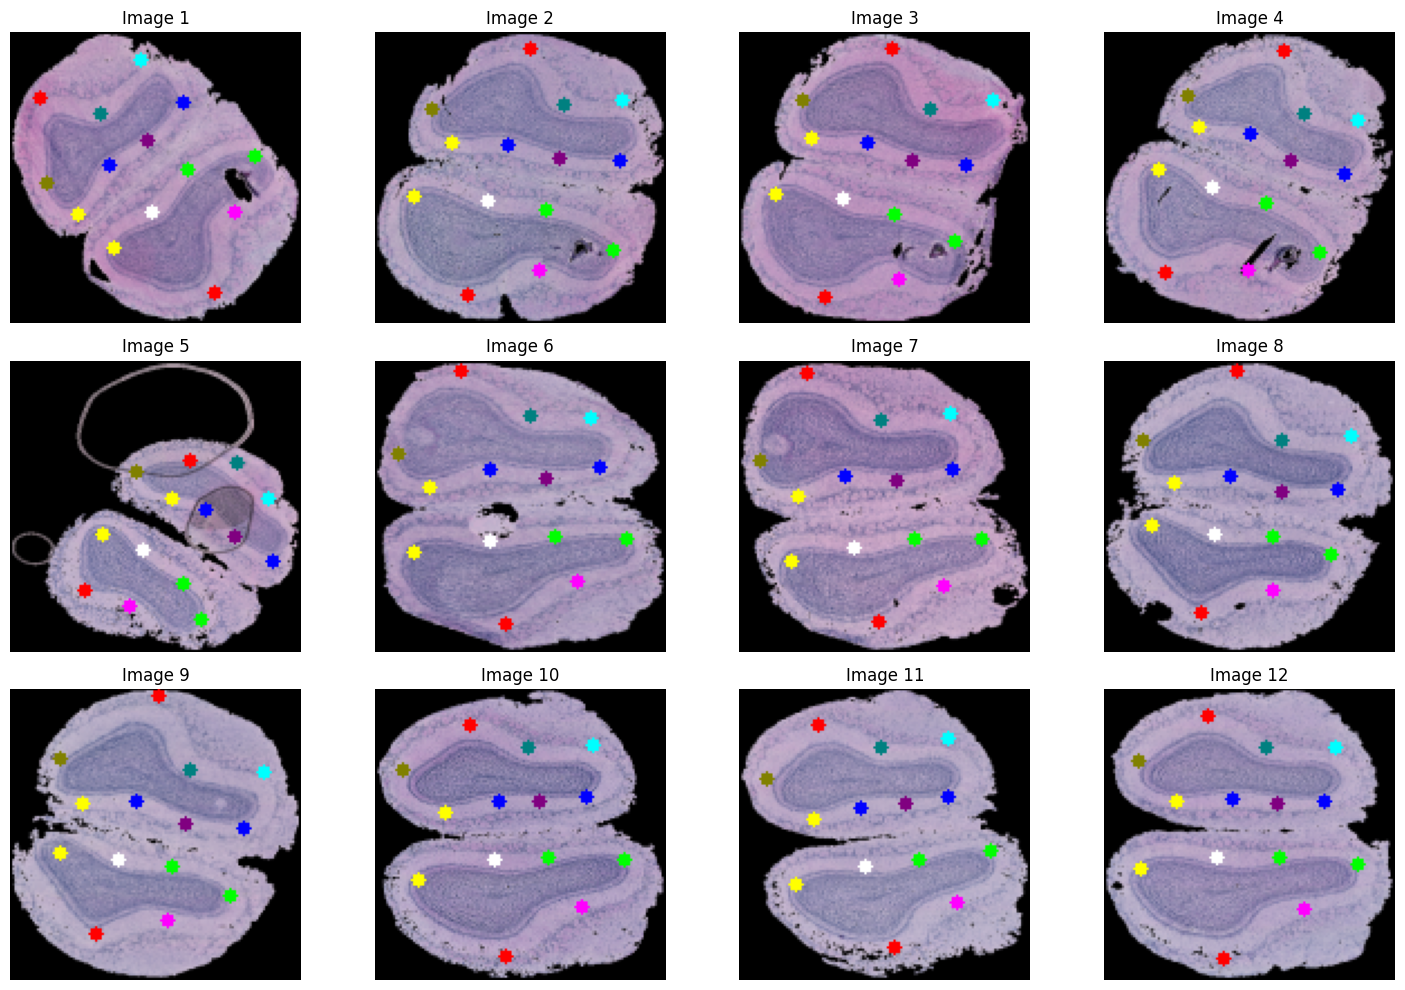

In [7]:
fig, axs = plt.subplots(3, 4, figsize=(15, 10))  # adjust the size as needed
axs = axs.ravel()

for i in range(len(np_img)):
    img = np_img[i]
    axs[i].imshow(img)
    axs[i].set_title(f"Image {i+1}")
    axs[i].axis('off')  # to hide the axis

plt.tight_layout()
plt.show()


### Warping

Let's warp all images to the first image

In [8]:
dst_pts = create_target_landmarks(pts, 0)

Let's create a plotting function

In [9]:
def plot_warped_images(mapped_imgs:torch.Tensor, dst_pts: torch.Tensor)->None:
    np_img = toImg(mapped_imgs.cuda()[:,:3], dst_pts, 128)
    fig, axs = plt.subplots(3, 4, figsize=(15, 10))  # adjust the size as needed
    axs = axs.ravel()

    for i in range(12):
        img = np_img[i]
        axs[i].imshow(img)
        if i == 0:
            axs[i].set_title(f"Target")
        else: 
            axs[i].set_title(f"Warped: Image {i+1}")
        axs[i].axis('off')  # to hide the axis

    plt.tight_layout()
    plt.show()

#### Homography

In [10]:
homo_transform = Homo()

In [11]:
#Warp image
mapped_imgs = homo_transform.warp_img(image.cuda(), pts, dst_pts)
#Warp landmarks
mapped_pts = homo_transform.warp_pts(pts, dst_pts, pts)

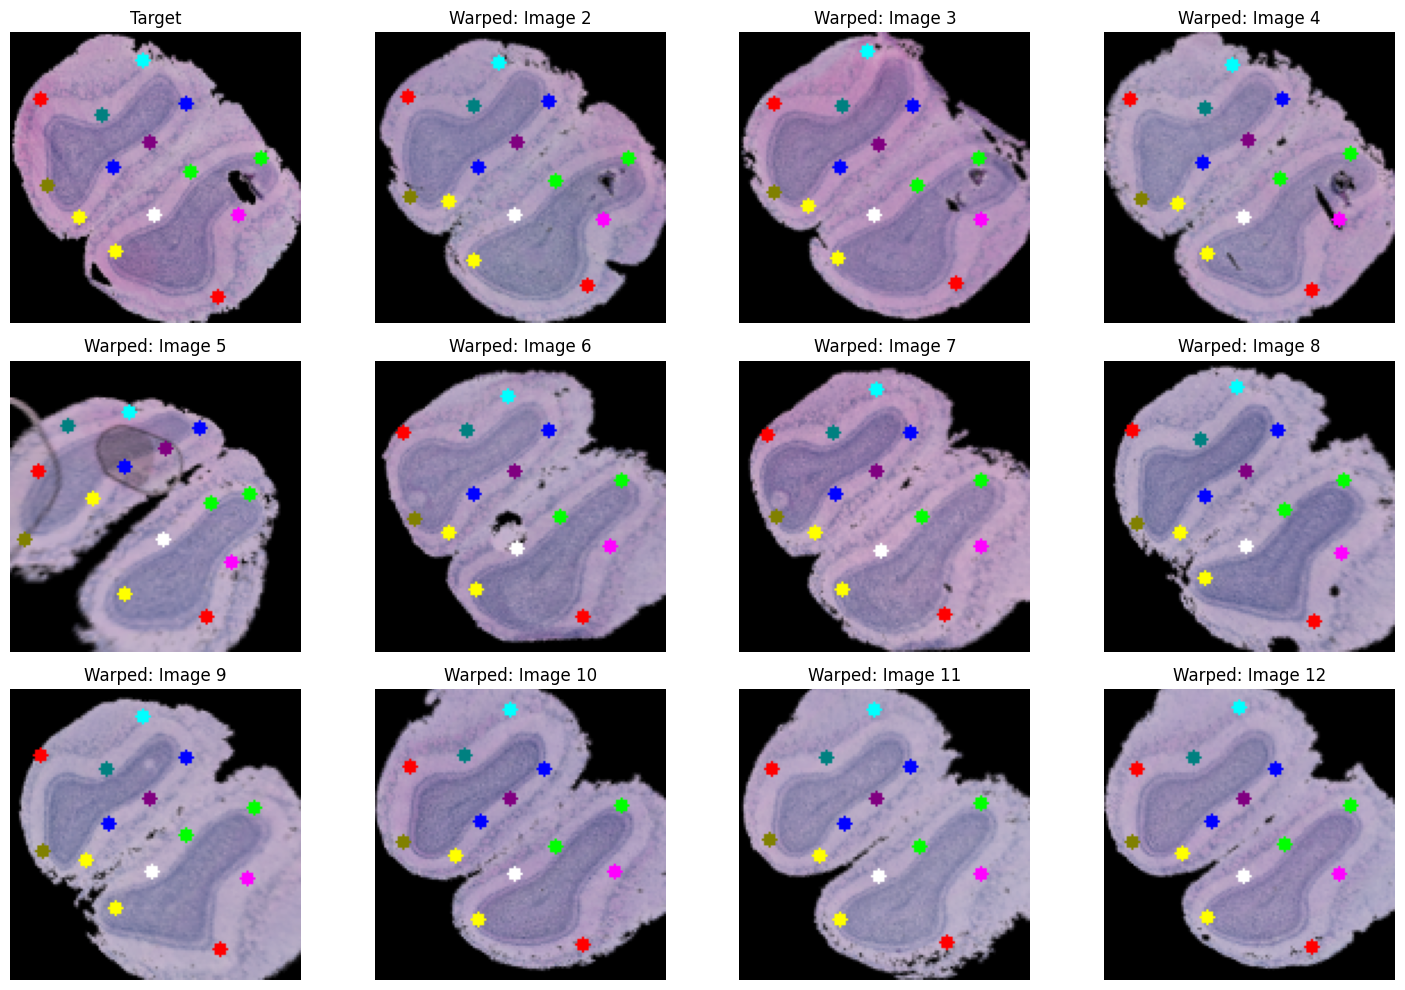

In [12]:
plot_warped_images(mapped_imgs, mapped_pts)

The landmarks used here were detected by using TPS and might not be optimal for Homography. Some images get a bit wierdly warped such as e.g., 

#### Rigid transformation

In [13]:
rigid_transform = Rigid()

In [14]:
#warp images
mapped_imgs = rigid_transform.warp_img(image.cuda(), pts, dst_pts, (130, 130))
#warp landmarks
mapped_pts = rigid_transform.warp_pts(pts, dst_pts, pts)

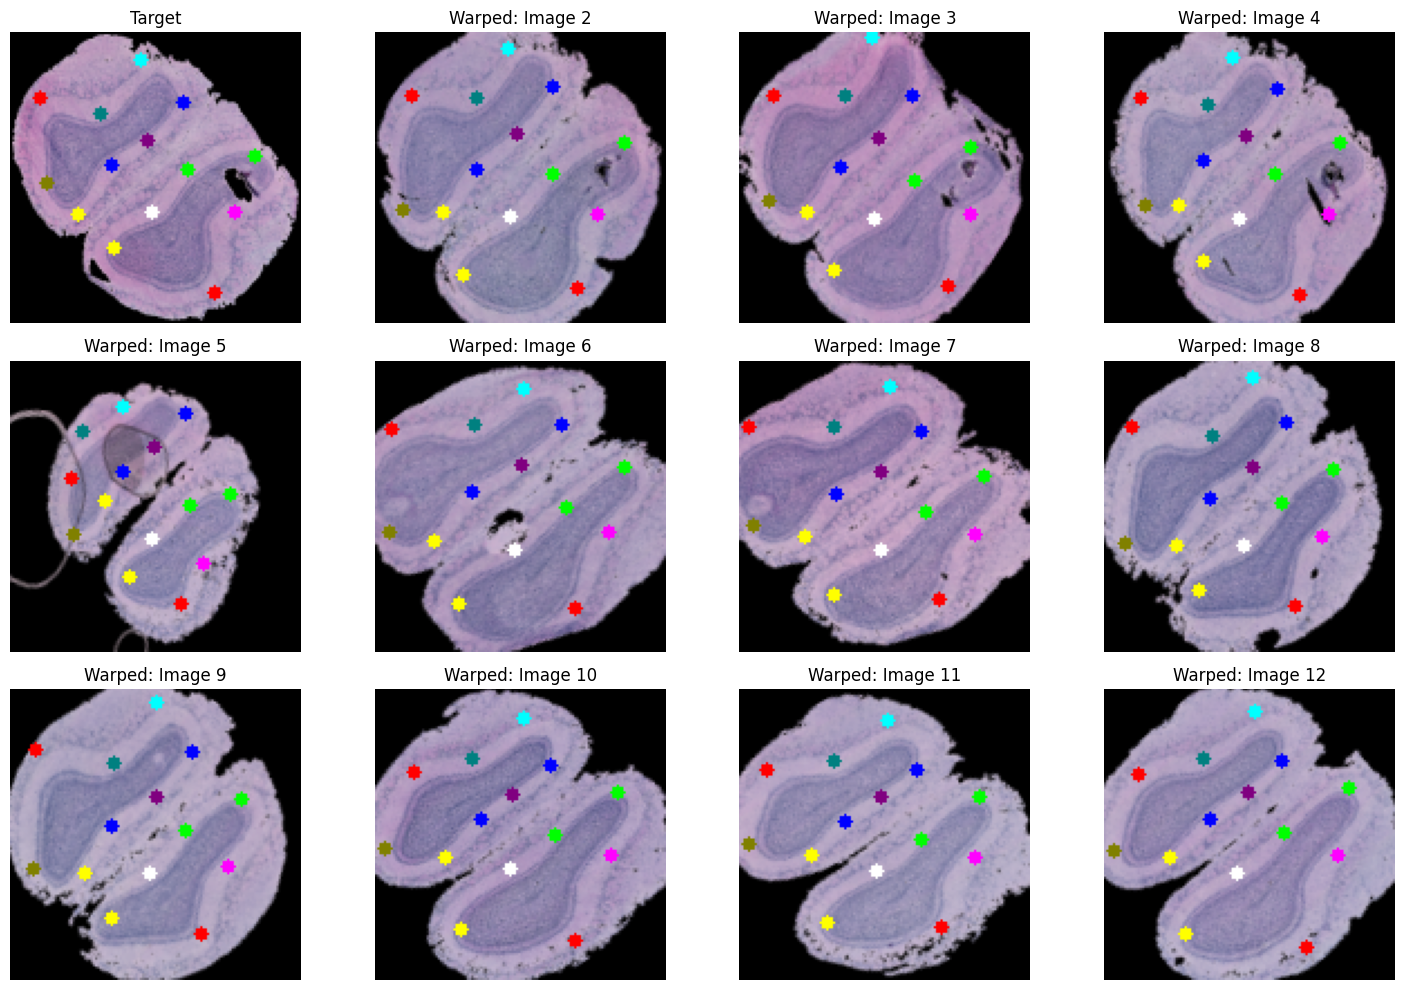

In [15]:
plot_warped_images(mapped_imgs, mapped_pts)

#### Affine transform

In [16]:
tps_transform = TPS()

We can get affine transform by setting the regularizer in the TPS to something extremely high

In [17]:
mapped_imgs = tps_transform.warp_img(image.cuda(), pts, dst_pts, reg=1e20, norm=True)
mapped_pts = tps_transform.warp_pts(pts, dst_pts, pts, reg=1e20)

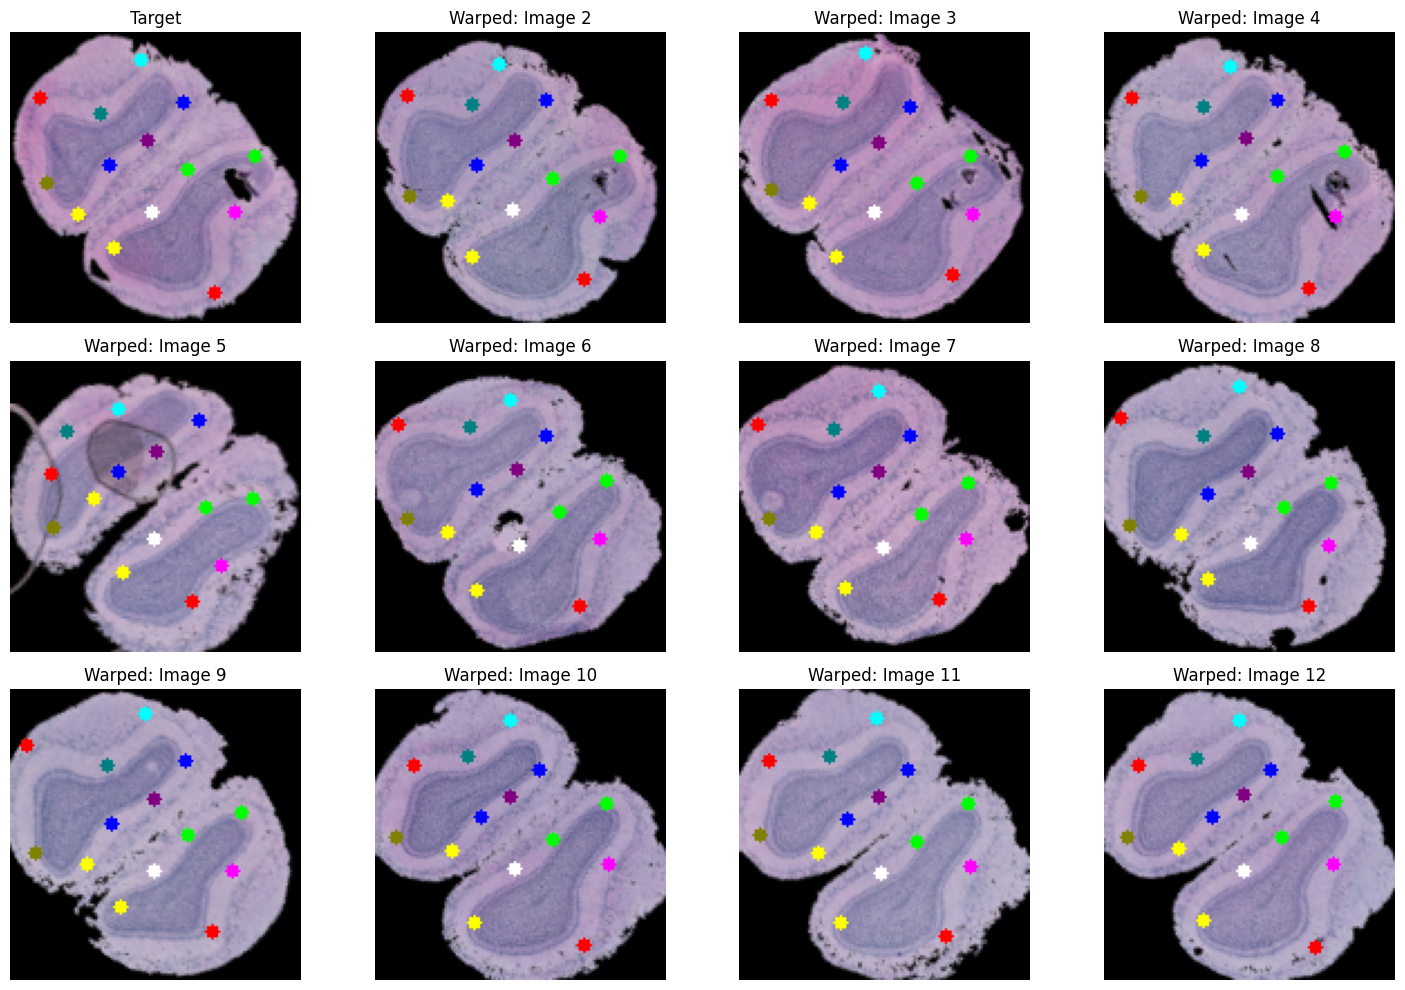

In [18]:
plot_warped_images(mapped_imgs, mapped_pts)

#### Thin Plate Splines

In [19]:
mapped_imgs = tps_transform.warp_img(image.cuda(), pts, dst_pts, reg=0, norm=True)
mapped_pts = tps_transform.warp_pts(pts, dst_pts, pts)

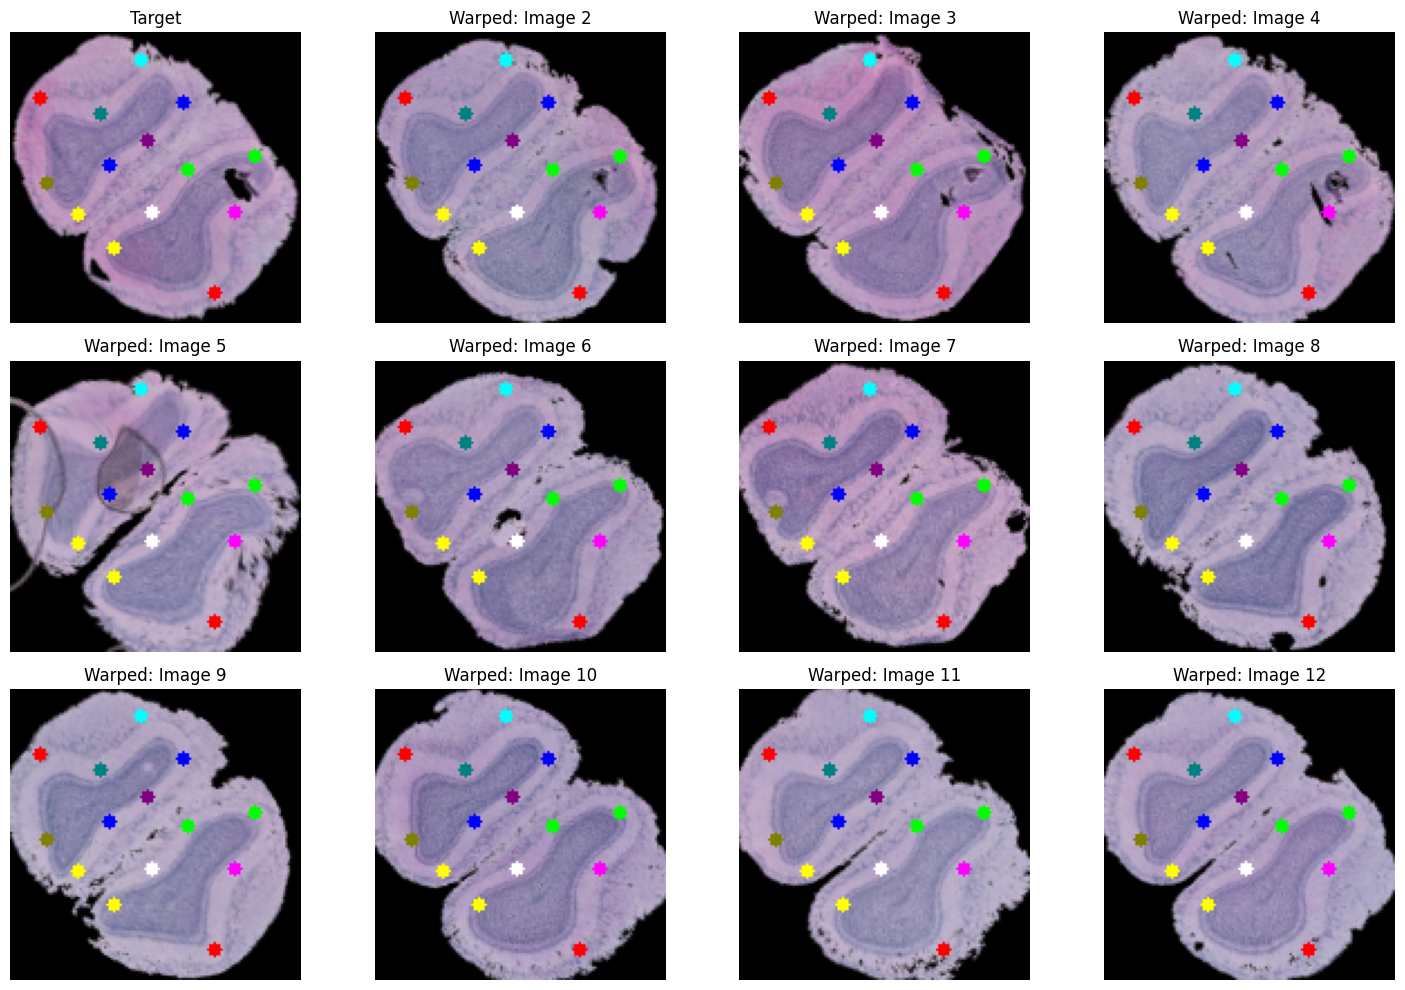

In [20]:
plot_warped_images(mapped_imgs, mapped_pts)